In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, collections, os, argparse
%matplotlib inline  

# Download the 10x Dataset `1k Brain Cells from an E18 Mouse (v2 chemistry)`

10x datasets are available at
https://support.10xgenomics.com/single-cell-gene-expression/datasets

The page for the `1k Brain Cells from an E18 Mouse (v2 chemistry)` dataset is
https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/neuron_1k_v2

But the FASTQ files (7.4GB) can be downloaded with `wget` directly from http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v2/neuron_1k_v2_fastqs.tar

In the cell below we check if the dataset file `neuron_1k_v2_fastqs.tar` already exists. If not we download the dataset to the same directory as this notebook


In [57]:
#Check if the file was downloaded already before doing wget:
if not (os.path.isfile('./neuron_1k_v2_fastqs.tar')): 
    # the `!` means we're running a command line statement (rather than python)  
    !wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v2/neuron_1k_v2_fastqs.tar
else: print('Dataset already downloaded!')


Dataset already downloaded!


In [3]:
# now we untar the fastq files on neuron_1k_v2_fastqs folder
!tar -xvf ./neuron_1k_v2_fastqs.tar

neuron_1k_v2_fastqs/
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_I1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R2_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_I1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R2_001.fastq.gz


# Buiding the kallisto index

First make sure that kallisto is installed and the version is greater than 0.45

If it's not installed, see instructions at https://pachterlab.github.io/kallisto/download

In [4]:
!kallisto version 

kallisto, version 0.45.0


First we build the kallisto index for the dataset. 
The index is built from the published reference transcriptome for each organism.
Building the index takes a few minutes and needs to be done only once for each organism.

### Download reference transcriptome from ensembl
In order to do that we first download the mouse transcriptome from ensembl, you can see the reference genomes they have at https://uswest.ensembl.org/info/data/ftp/index.html

In [5]:
#Check if the file was downloaded already before doing wget:
if not (os.path.isfile('Mus_musculus.GRCm38.cdna.all.fa.gz')): 
    # the `!` means we're running a command line statement (rather than python)  
    !wget ftp://ftp.ensembl.org/pub/release-94/fasta/mus_musculus/cdna/Mus_musculus.GRCm38.cdna.all.fa.gz
else: print('Mouse transcriptome already downloaded!')


--2018-12-03 17:02:29--  ftp://ftp.ensembl.org/pub/release-94/fasta/mus_musculus/cdna/Mus_musculus.GRCm38.cdna.all.fa.gz
           => ‘Mus_musculus.GRCm38.cdna.all.fa.gz’
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.8
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.8|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-94/fasta/mus_musculus/cdna ... done.
==> SIZE Mus_musculus.GRCm38.cdna.all.fa.gz ... 50809568
==> PASV ... done.    ==> RETR Mus_musculus.GRCm38.cdna.all.fa.gz ... done.
Length: 50809568 (48M) (unauthoritative)

100%[======================================>] 50,809,568  3.25MB/s   in 16s    

2018-12-03 17:02:52 (3.03 MB/s) - ‘Mus_musculus.GRCm38.cdna.all.fa.gz’ saved [50809568]



In [6]:
### Now we can build the index
if not (os.path.isfile('mouse_transcripts.idx')): 
    !kallisto index -i mouse_transcripts.idx Mus_musculus.GRCm38.cdna.all.fa.gz
else: print ('Mouse transcript index already exist!')


[build] loading fasta file Mus_musculus.GRCm38.cdna.all.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 600 target sequences
[build] warning: replaced 3 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 711215 contigs and contains 98989067 k-mers 



# Preparing transcript_to_gene.tsv file process the single cell data with kallisto bus

Depending on which transcriptome you used, you will need to create a file translating transcripts to genes. This notebook assumes the file is in `transcript_to_gene.tsv`, for ensembl transcriptomes these can be generated using biomart.

The general format of `transcript_to_gene.tsv` is

```
ENST00000632684.1	ENSG00000282431.1
ENST00000434970.2	ENSG00000237235.2
ENST00000448914.1	ENSG00000228985.1
ENST00000415118.1	ENSG00000223997.1
ENST00000631435.1	ENSG00000282253.1
...
```

To create the `transcript_to_gene.tsv` we fetch and parse the mouse GTF file from ensembl.

The reference GTF files are available at https://uswest.ensembl.org/info/data/ftp/index.html

The mouse ones which we use are at ftp://ftp.ensembl.org/pub/release-94/gtf/mus_musculus

In [7]:
#Check if the file was downloaded already before doing wget:
if not (os.path.isfile('Mus_musculus.GRCm38.94.gtf.gz') or os.path.isfile('Mus_musculus.GRCm38.94.gtf')): 
    # the `!` means we're running a command line statement (rather than python)  
    !wget ftp://ftp.ensembl.org/pub/release-94/gtf/mus_musculus/Mus_musculus.GRCm38.94.gtf.gz
else: print('Mouse transcriptome already downloaded!')


--2018-12-03 17:06:41--  ftp://ftp.ensembl.org/pub/release-94/gtf/mus_musculus/Mus_musculus.GRCm38.94.gtf.gz
           => ‘Mus_musculus.GRCm38.94.gtf.gz’
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.8
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.8|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-94/gtf/mus_musculus ... done.
==> SIZE Mus_musculus.GRCm38.94.gtf.gz ... 29397390
==> PASV ... done.    ==> RETR Mus_musculus.GRCm38.94.gtf.gz ... done.
Length: 29397390 (28M) (unauthoritative)

100%[======================================>] 29,397,390  3.00MB/s   in 9.3s   

2018-12-03 17:06:57 (3.01 MB/s) - ‘Mus_musculus.GRCm38.94.gtf.gz’ saved [29397390]



In [8]:
# Unzip the file
!gunzip ./Mus_musculus.GRCm38.94.gtf.gz

## Create transcript_to_gene.tsv

Now we can use the cells below to parse the GTF file and keep only the transcript mapping as a tsv file in the format below.
```
ENST00000632684.1	ENSG00000282431.1
ENST00000434970.2	ENSG00000237235.2
ENST00000448914.1	ENSG00000228985.1
```

In [41]:
def create_transcript_list(input, use_name = True, use_version = True):
    r = {}
    for line in input:
        if len(line) == 0 or line[0] == '#':
            continue
        l = line.strip().split('\t')
        if l[2] == 'transcript':
            info = l[8]
            d = {}
            for x in info.split('; '):
                x = x.strip()
                p = x.find(' ')
                if p == -1:
                    continue
                k = x[:p]
                p = x.find('"',p)
                p2 = x.find('"',p+1)
                v = x[p+1:p2]
                d[k] = v


            if 'transcript_id' not in d or 'gene_id' not in d:
                continue

            tid = d['transcript_id']
            gid = d['gene_id']
            if use_version:
                if 'transcript_version' not in d or 'gene_version' not in d:
                    continue

                tid += '.' + d['transcript_version']
                gid += '.' + d['gene_version']
            gname = None
            if use_name:
                if 'gene_name' not in d:
                    continue
                gname = d['gene_name']

            if tid in r:
                continue

            r[tid] = (gid, gname)
    return r



def print_output(output, r, use_name = True):
    for tid in r:
        if use_name:
            output.write("%s\t%s\t%s\n"%(tid, r[tid][0], r[tid][1]))
        else:
            output.write("%s\t%s\n"%(tid, r[tid][0]))

In [42]:
with open('./Mus_musculus.GRCm38.94.gtf') as file:
    r = create_transcript_list(file, use_name = True, use_version = True)
with open('transcript_to_gene.tsv', "w+") as output:
    print_output(output, r, use_name = True)
print('Created transcript_to_gene.tsv file')

Created transcript_to_gene.tsv file


# Run kallisto bus
kallisto bus supports several single cell sequencing technologies, as you can see below. We'll be using 10xv2            

In [11]:
!kallisto bus --list

List of supported single cell technologies

short name       description
----------       -----------
10Xv1            10X chemistry version 1
10Xv2            10X chemistry verison 2
DropSeq          DropSeq
inDrop           inDrop
CELSeq           CEL-Seq
CELSeq2          CEL-Seq version 2
SCRBSeq          SCRB-Seq



In [12]:
!kallisto bus -i mouse_transcripts.idx  -o out_1k_mouse_brain_v2 -x 10xv2 -t 4 \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R1_001.fastq.gz \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R2_001.fastq.gz \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R1_001.fastq.gz \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R2_001.fastq.gz


[index] k-mer length: 31
[index] number of targets: 115,270
[index] number of k-mers: 98,989,067
[index] number of equivalence classes: 419,171
[quant] will process sample 1: ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R1_001.fastq.gz
                               ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R2_001.fastq.gz
[quant] will process sample 2: ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R1_001.fastq.gz
                               ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R2_001.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 104,846,299 reads, 73,297,108 reads pseudoaligned


### The `matrix.ec` file

The `matrix.ec` is generated by kallisto and connects the equivalence class ids to sets of transcripts. The format looks like
~~~
0	0
1	1
2	2
3	3
4	4
...

884398	26558,53383,53384,69915,69931,85319,109252,125730
884399	7750,35941,114698,119265
884400	9585,70083,92571,138545,138546
884401	90512,90513,134202,159456
~~~

In [13]:
#load transcript to gene file
tr2g = {}
trlist = []
with open('./transcript_to_gene.tsv') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('./out_1k_mouse_brain_v2/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

### Processing the BUS file

For these notebooks we will work with the text file that `BUStools` produces, rather than the raw `BUS` file. 
To install `BUStools` see https://github.com/BUStools/bustools

We discard any barcodes that don't have more 10 UMIs 

To produce the text file, starting with the `output.bus` file produced by kallisto, we first sort it on bustools:
```
bustools sort -o output.sorted output.bus
```
Then we convert it to txt:
```
bustools text -o output.sorted.txt output.sorted
```



In [14]:
#sort bus file
!bustools sort -o ./out_1k_mouse_brain_v2/output.sorted ./out_1k_mouse_brain_v2/output.bus

Read in 73297108 number of busrecords
All sorted


In [15]:
# convert the sorted busfile to txt
!bustools text -o ./out_1k_mouse_brain_v2/output.sorted.txt ./out_1k_mouse_brain_v2/output.sorted

Read in 21115457 number of busrecords


# Plot the bus file results

In [16]:
import csv
from collections import defaultdict

# precompute because this is constant per ec
ec2g = {ec:frozenset(tr2g[trlist[t]] for t in ecs[ec]) for ec in ecs}

# first pass: collect gene sets
bcu_gs = dict()

with open('./out_1k_mouse_brain_v2/output.sorted.txt') as f:
    rdr = csv.reader(f, delimiter='\t')
    for bar,umi,ec,_ in rdr:
        gs = ec2g[int(ec)]

        if (bar,umi) in bcu_gs:
            bcu_gs[bar,umi].intersection_update(gs)
        else:
            bcu_gs[bar,umi] = set(gs)

# second pass: compute gene counts
cell_gene = defaultdict(lambda: defaultdict(float))

for (bar,umi),gs in bcu_gs.items():
    for g in gs:
        cell_gene[bar][g] += 1.0 / len(gs)

# finally: filter out barcodes below threshold
cell_gene = {bar:cell_gene[bar] for bar in cell_gene
              if sum(cell_gene[bar].values()) >= 10.0}

In [17]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s
    

### Plot counts

1291


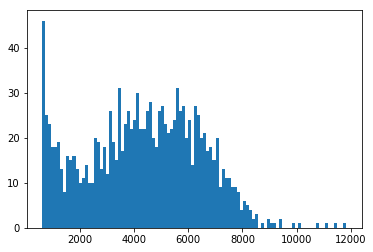

In [20]:
bcv = [x for b,x in barcode_hist.items() if x > 600 and x < 12000]
_ = plt.hist(bcv,bins=100)
print(len(bcv))

## Export to Seurat compatible matrices

In [104]:
outfile = 'matrix.mtx'

gene_to_id = dict((g,i+1) for i,g in enumerate(genes))
barcodes_to_use = [b for b,x in barcode_hist.items() if x > 600 and x < 12000]

num_entries = 0
for barcode in barcodes_to_use:
    num_entries += len([x for x in cell_gene[barcode].values() if round(x)>0])



In [105]:
with open(outfile, 'w') as of:
    of.write('%%MatrixMarket matrix coordinate real general\n%\n')
    #number of genes
    of.write("%d %d %d\n"%(len(genes), len(barcodes_to_use), num_entries))
    bcid = 0
    for barcode in barcodes_to_use:
        bcid += 1
        cg = cell_gene[barcode]
        gl = [(gene_to_id[g],round(cg[g])) for g in cg if round(cg[g]) > 0]
        gl.sort()
        for x in gl:
            of.write("%d %d %d\n"%(x[0],bcid,x[1]))
    

### Take a look at the first few lines of the count matrix we just exported

In [129]:
from scipy.io import mmread
import pandas as pd

In [142]:
count_matrix = mmread('matrix.mtx')
count_matrix

<54532x1291 sparse matrix of type '<class 'numpy.float64'>'
	with 2883528 stored elements in COOrdinate format>

In [143]:
dense_count_matrix = count_matrix.todense()

In [ ]:
counts_df = pd.DataFrame(dense_count_matrix)

In [160]:
#export the count matrix to a csv file for inspection
count_df.to_csv('counts_df.csv')

In [159]:
#show the first 30 genes for a few cells
counts_df.head(30)

,0,1,2,3,4,5,6,7,8,9,...,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [106]:
gene_names = {}
with open('transcript_to_gene.tsv') as f:
    f.readline()
    for line in f:
        g,t,gn = line.split()
        gene_names[g] = gn


In [107]:
id_to_genes = dict((i,g) for (g,i) in gene_to_id.items())
gl = []
for i in range(1,len(genes)+1):
    g = id_to_genes[i]
    gid = g[:g.find('.')]
    if gid in gene_names:
        gn = gene_names[gid]
    else:
        gn = ''
    gl.append((g,gn))

with open('genes.tsv','w') as of:
    for g,gn in gl:
        of.write("%s\t%s\n"%(g,gn))
        
with open('barcodes.tsv','w') as of:
    of.write('\n'.join(x + '-1' for x in barcodes_to_use))
    of.write('\n')

In [108]:
#show some of the genes in the gene list
gl[:10]

[('ENSMUSG00000086423.1', ''),
 ('ENSMUSG00000113025.1', ''),
 ('ENSMUSG00000074268.4', ''),
 ('ENSMUSG00000115936.1', ''),
 ('ENSMUSG00000098798.1', ''),
 ('ENSMUSG00000112810.1', ''),
 ('ENSMUSG00000111169.1', ''),
 ('ENSMUSG00000065600.1', ''),
 ('ENSMUSG00000113773.1', ''),
 ('ENSMUSG00000063179.13', '')]

In [109]:
#length of the gene list
len(gl)

54532

# Make PCA, UMAP and tSNE plots with scanpy

For this section to work you need to have scanpy installed. 

For help installing scanpy see https://icb-scanpy.readthedocs-hosted.com/en/latest/installation.html

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()


scanpy==1.3.3 anndata==0.6.13 numpy==1.15.2 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 


In [126]:
adata = sc.read('./matrix.mtx', cache=True).T  # transpose the data
adata.var_names = pd.read_csv('./genes.tsv', header=None,)[0]
adata.obs_names = pd.read_csv('./barcodes.tsv', header=None)[0]

In [112]:
%%time
sc.pp.filter_genes(adata, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 7.57 GB, difference +0.09 GB
CPU times: user 388 ms, sys: 198 ms, total: 587 ms
Wall time: 584 ms


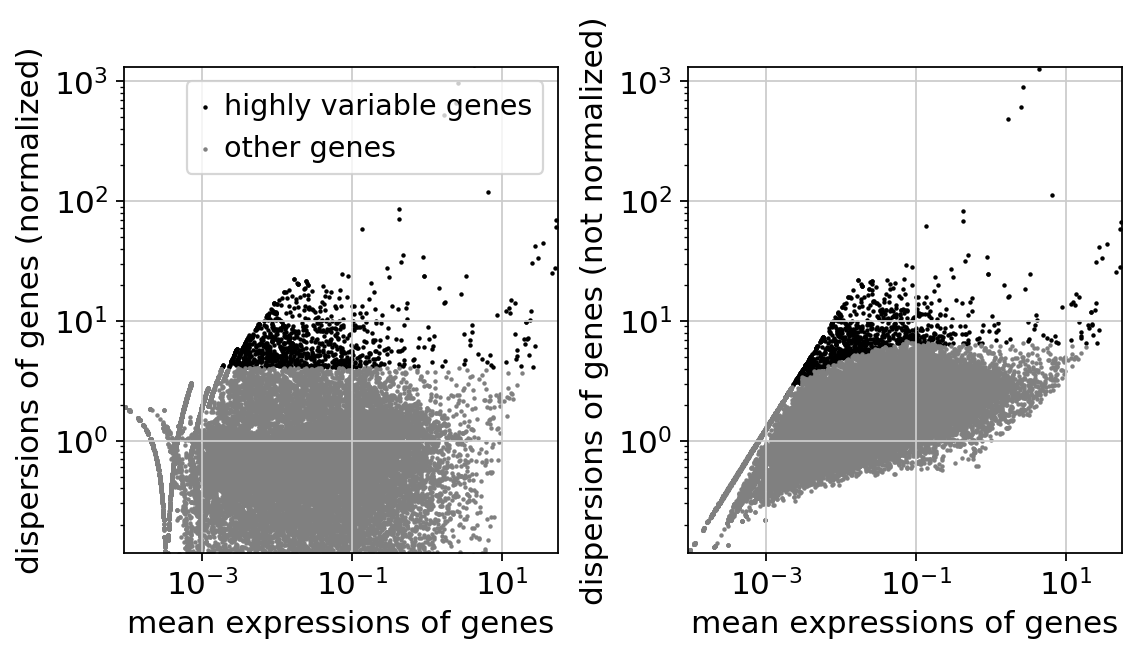

In [113]:
sc.pl.filter_genes_dispersion(filter_result, log=True)


In [114]:
%%time
adata = adata[:, filter_result.gene_subset]  # filter genes
sc.pp.normalize_per_cell(adata)  # need to redo normalization after filtering
sc.pp.log1p(adata)  # log transform: X = log(X + 1)
sc.pp.scale(adata)
# the PCA is *not* contained in the recipe sc.pp.recipe_zheng17(adata)
sc.tl.pca(adata, n_comps=50)
sc.logging.print_memory_usage()

Memory usage: current 7.57 GB, difference +0.00 GB
CPU times: user 11.6 s, sys: 18.4 s, total: 30.1 s
Wall time: 379 ms


## Plot PCA results

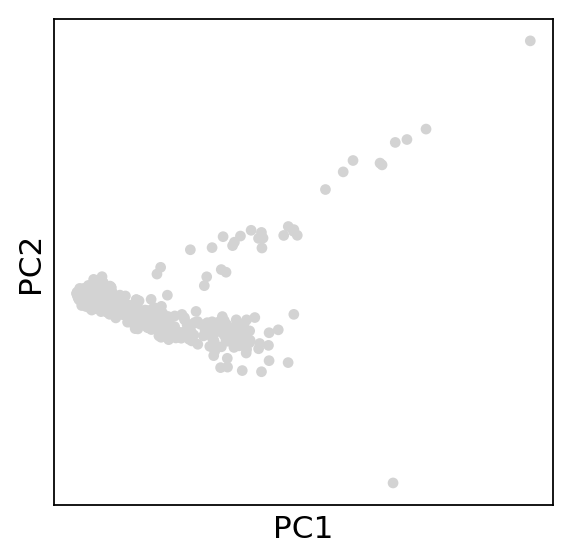

In [124]:
sc.pl.pca(adata)

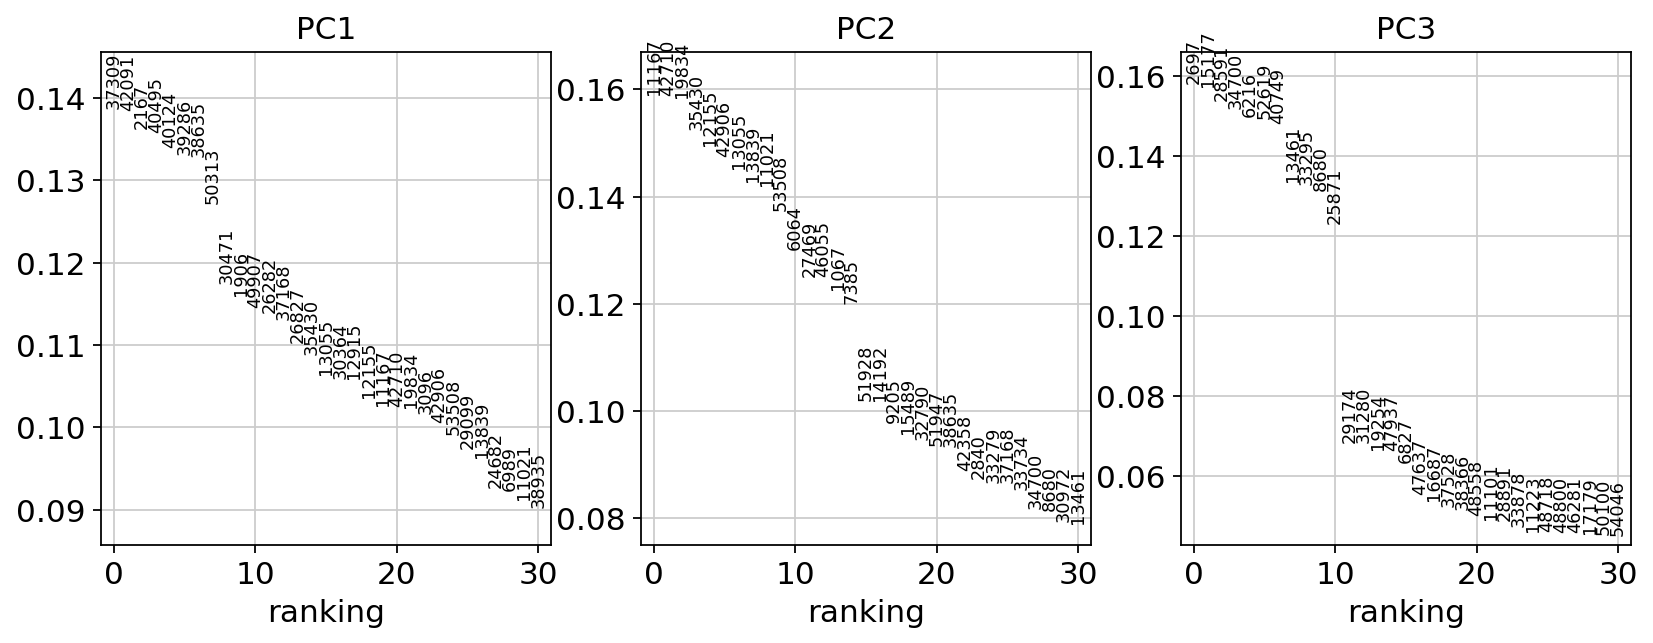

In [125]:
sc.pl.pca_loadings(adata)


### Constructing and visualizing the single-cell graph

This will construct the single-cell graph - usually a knn graph - that describes cells in their relation to their neighbors.

In [116]:
%%time
sc.pp.neighbors(adata)
sc.logging.print_memory_usage()

Memory usage: current 7.57 GB, difference +0.00 GB
CPU times: user 3.15 s, sys: 4.84 s, total: 7.99 s
Wall time: 1.24 s


# Plotting UMAP
UMAP (Uniform Manifold Approximation and Projection) is a manifold learning technique suitable for visualizing high-dimensional data. Besides tending to be faster than tSNE, it optimizes the embedding such that it best reflects the topology of the data, which we represent throughout Scanpy using a neighborhood graph. 

In [117]:
%%time
sc.tl.umap(adata)
sc.logging.print_memory_usage()

Memory usage: current 7.57 GB, difference +0.00 GB
CPU times: user 6.64 s, sys: 7.14 s, total: 13.8 s
Wall time: 3.06 s


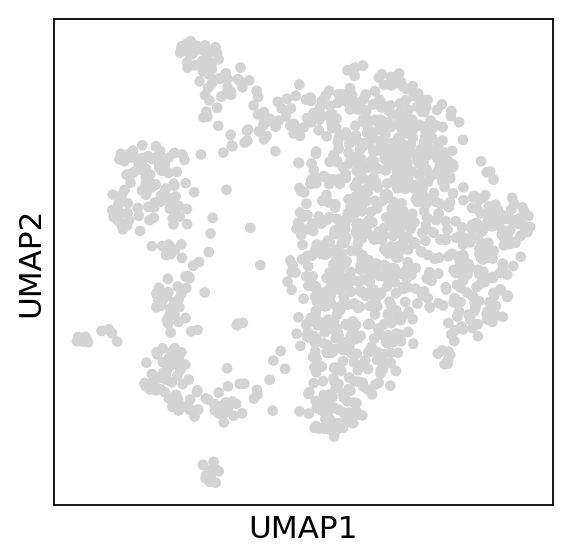

In [118]:
sc.pl.umap(adata)

## Visualization using tSNE

tSNE, by contrast with UMAP, optimizes the distribution of nearest-neighbor distances in the embedding such that these best match the distribution of distances in the high-dimensional space

In [120]:
%%time
sc.tl.tsne(adata)
sc.logging.print_memory_usage()

Memory usage: current 7.57 GB, difference +0.00 GB
CPU times: user 7.16 s, sys: 130 ms, total: 7.29 s
Wall time: 7.13 s


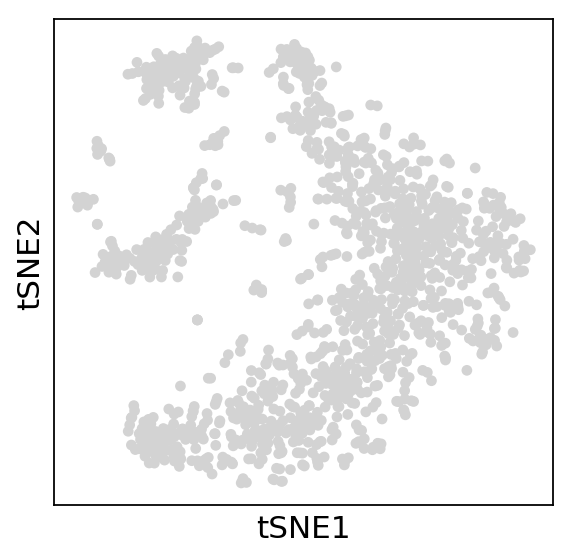

In [121]:
sc.tl.tsne(adata, n_pcs=20)
sc.pl.tsne(adata)